In [1]:
import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series

from warnings import simplefilter
simplefilter("ignore", FutureWarning)
%matplotlib inline

**Since we are not creative/imaginitive at all we are going to use the same Box-Jenkins univariate airline dataset.**

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

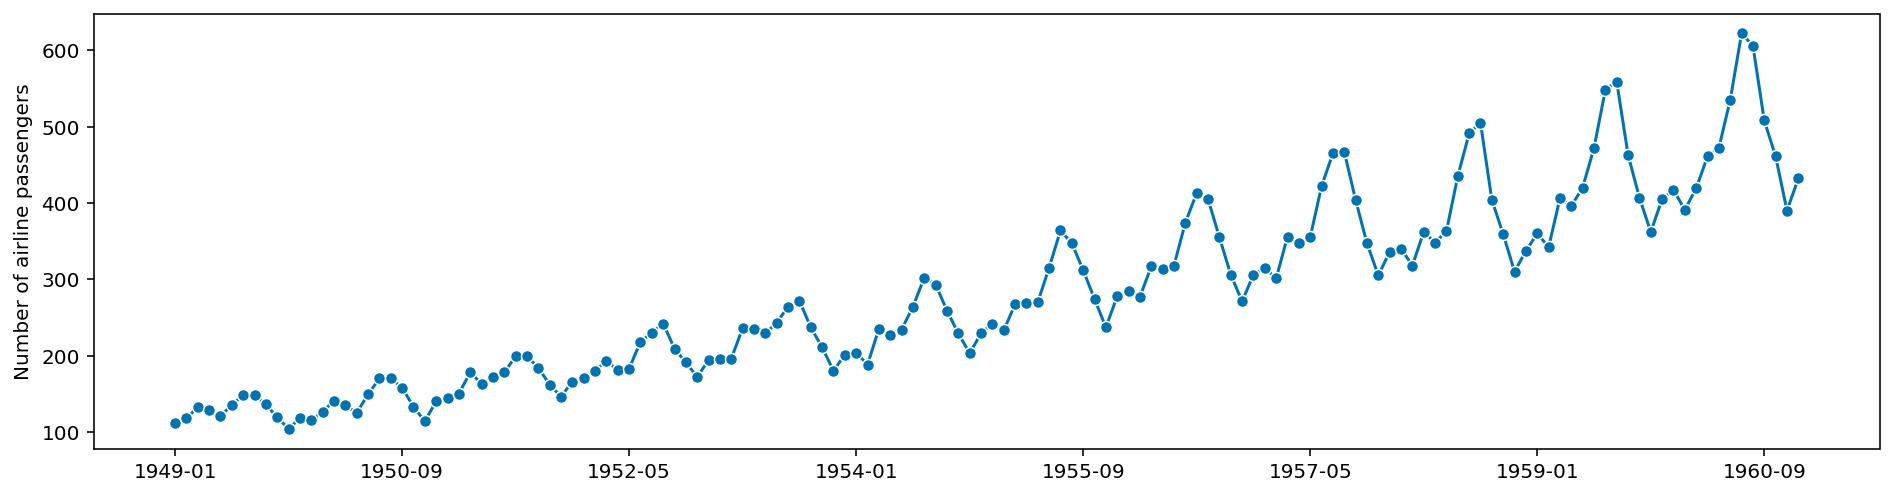

In [2]:
y = load_airline()
plot_series(y)

**Splitting the data into train and test subsamples**

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

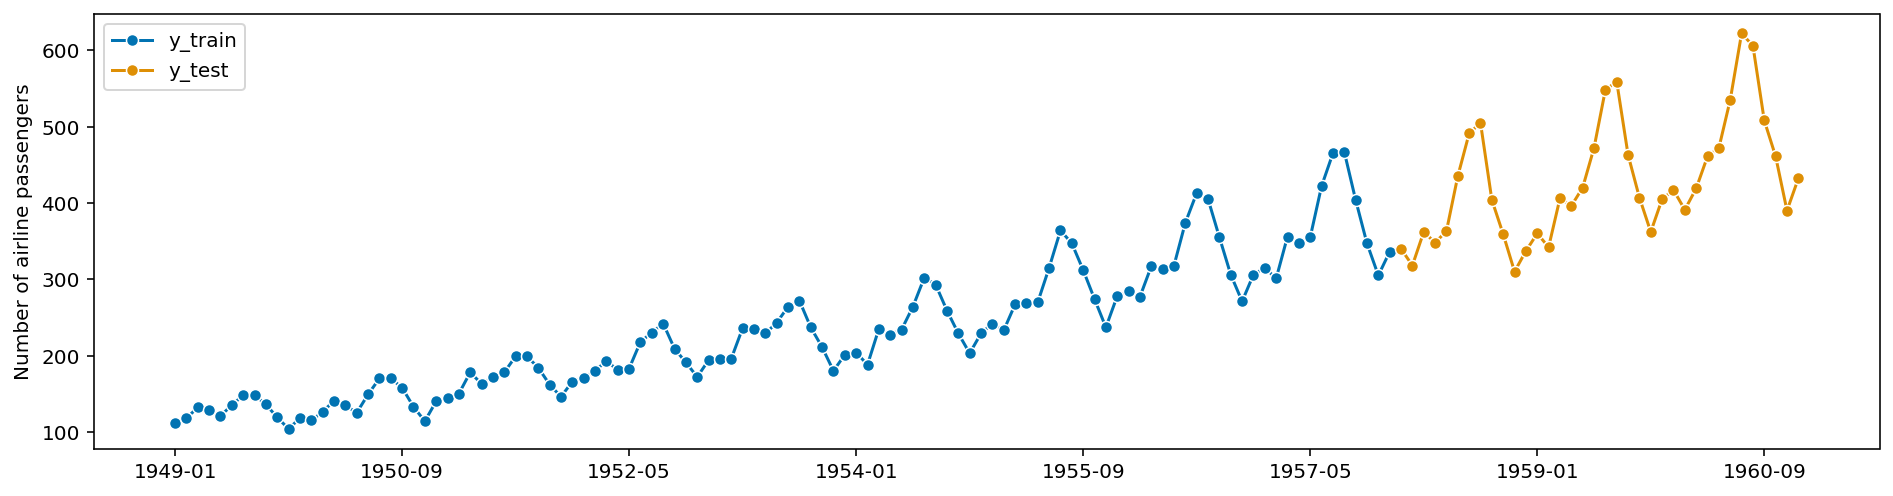

In [3]:
# test size is number of bservation which will comsidered as predicted
y_train, y_test = temporal_train_test_split(y, test_size=36)

#that is needed to not test our model on set on which it is learned, which is obviously look ambigous
plot_series(y_train, y_test, labels=["y_train", "y_test"])

**We love ETS models, hence we are going to consider them in this tutorial^_^**

**But before we start all the forecasting magic, let's define the forecasting horizon**

In [4]:
horizon = ForecastingHorizon(y_test.index, is_relative=False)
horizon

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', freq='M', is_relative=False)

**Let's try ETS(AAA):**

$$y_t = l_{t-1} + s_{t-m} + \varepsilon_t \\
l_t = l_{t-1} + b_{t-1} + \alpha \varepsilon_t \\
b_t = b_{t-1} + \beta \varepsilon_t \\
s_t = s_{t-m} + \gamma \varepsilon_t \\
$$

0.05027648058119676

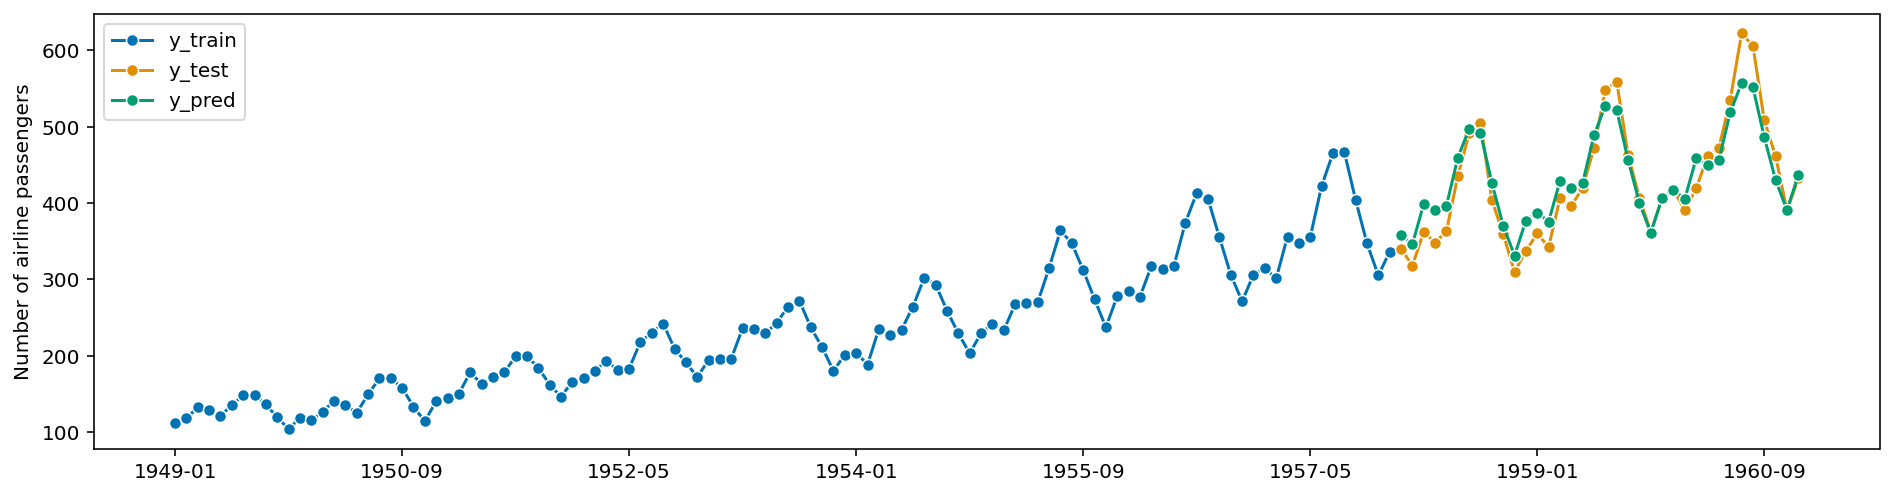

In [5]:
#trend and seosonality can be "additive" or "multiplicative"
model = ExponentialSmoothing(trend="additive", seasonal="additive", sp=12)
#sp - size of season period, from plot can be obtain that it will be 12 months

#fit our model on TRAIN set
model.fit(y_train)

#get predictions from fitted model
y_pred = model.predict(horizon)

#plotting predictions
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

**Some times it is hard or inefficent try to guess model parameters.**
**Fortunally we have alghorithm who can automatically diferent model and choose the best one.**
**Let's see what will be the output of AutoETS**


0.0631640040619606

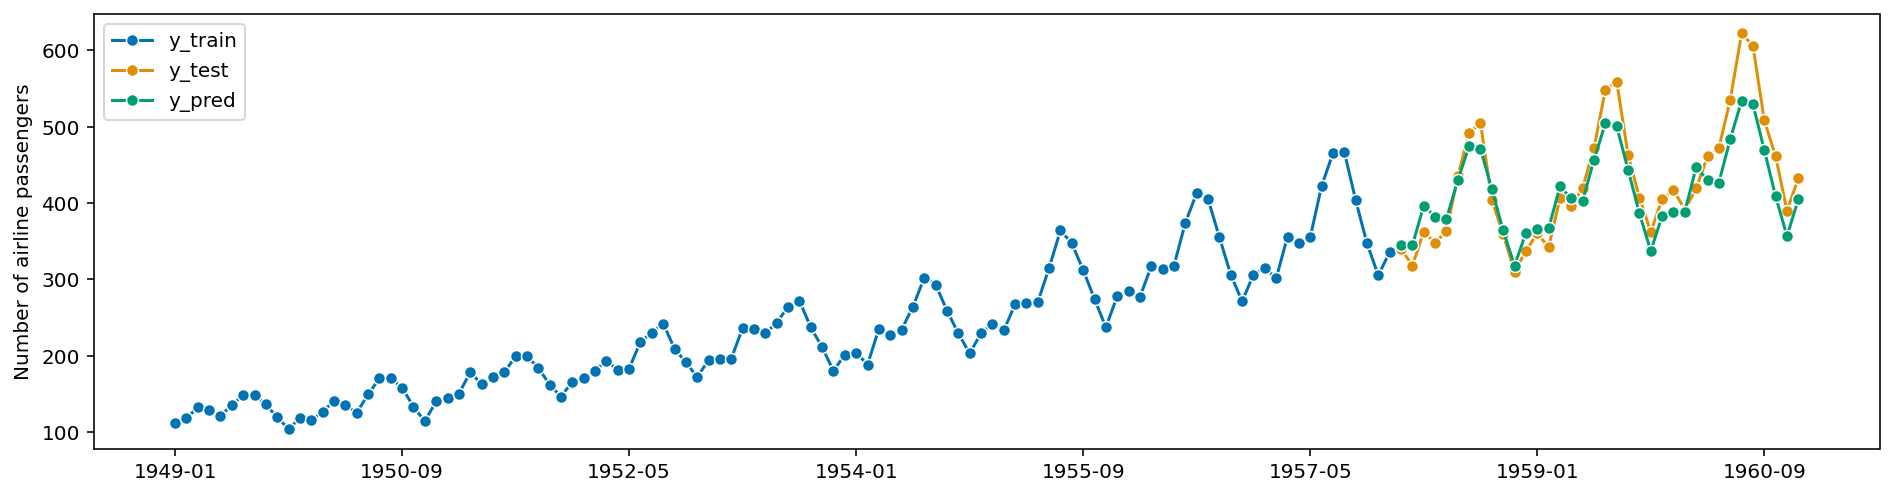

In [6]:
#actually we still need input seosonality size manually
model = AutoETS(auto=True, sp=12, n_jobs=-1)

#fit model
model.fit(y_train)

#obtain predictions
y_pred = model.predict(horizon)

#plotting predictions
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

**Unfortunately, ETS models implemented in sktime do not have predictive intervals. But, e.g. ThetaForecaster does have them. Hence**

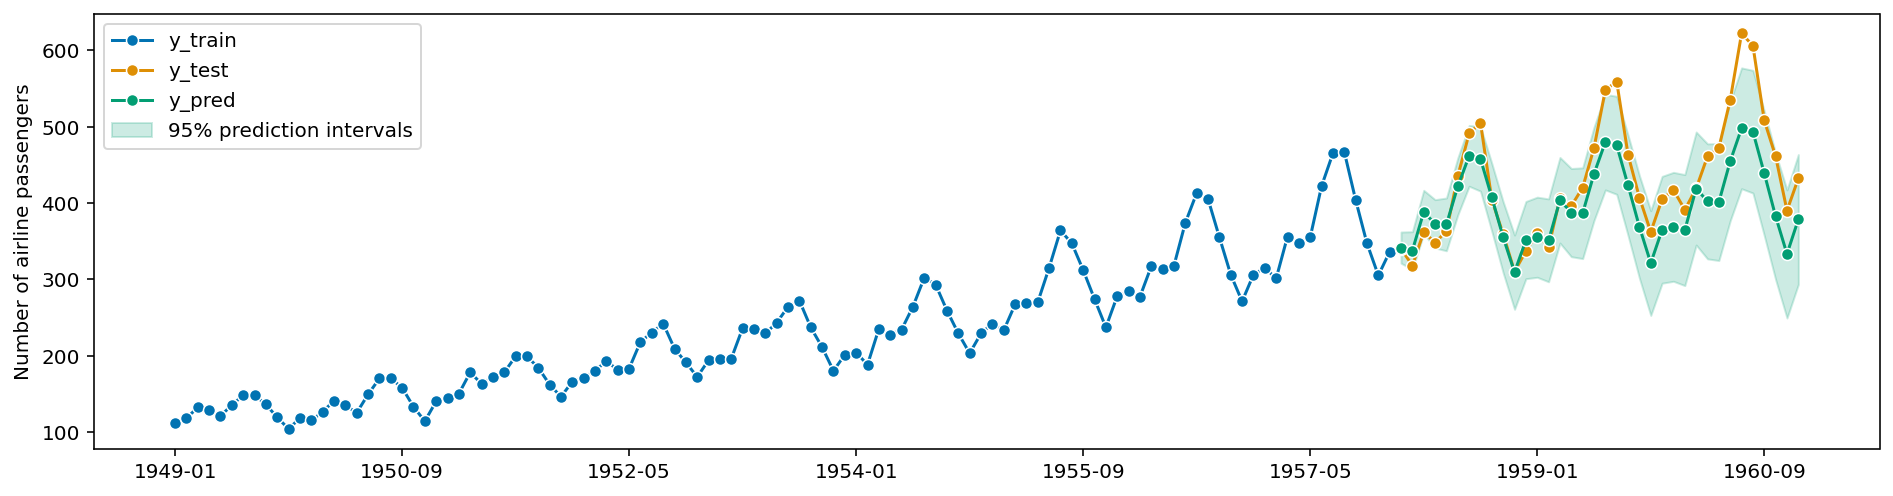

In [7]:
#using ThetaForecaster, which also finds parametrs automatically 
model = ThetaForecaster(sp=12)
#fit our model
model.fit(y_train)

#in alpha we specified alpha for our predicted interval, here it is 5%
y_pred, pred_ints = model.predict(horizon, return_pred_int=True, alpha = 0.05)
smape_loss(y_test, y_pred)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label="95% prediction intervals",
)#fill_between it is a great feature which allow us to draw shaded regions on plots to show intervals
ax.legend();

**Now let's compare several ETS models**

In [9]:
#defining a basic forecaster
forecaster = ExponentialSmoothing(sp=12)

#defining parameters grid
param_grid = {'trend': ["add", "multiplicative"], 
             'seasonal': ["add", "multiplicative"]}

#using sliding window cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
grid_search = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

#fit grid search
grid_search.fit(y_train)

#grid search predicts using the best over param_grid model
y_pred = grid_search.predict(horizon)

#let's see the results of our grid search
results = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_sMAPE')
results

,mean_fit_time,mean_score_time,param_seasonal,param_trend,params,mean_test_sMAPE,rank_test_sMAPE
2,0.120336,0.347513,multiplicative,add,"{'seasonal': 'multiplicative', 'trend': 'add'}",0.070872,1
0,0.140420,0.424813,add,add,"{'seasonal': 'add', 'trend': 'add'}",0.082917,2
3,0.181746,0.390050,multiplicative,multiplicative,"{'seasonal': 'multiplicative', 'trend': 'multi...",0.124518,3
1,0.185325,0.362238,add,multiplicative,"{'seasonal': 'add', 'trend': 'multiplicative'}",0.262812,4


0.05144389422883685

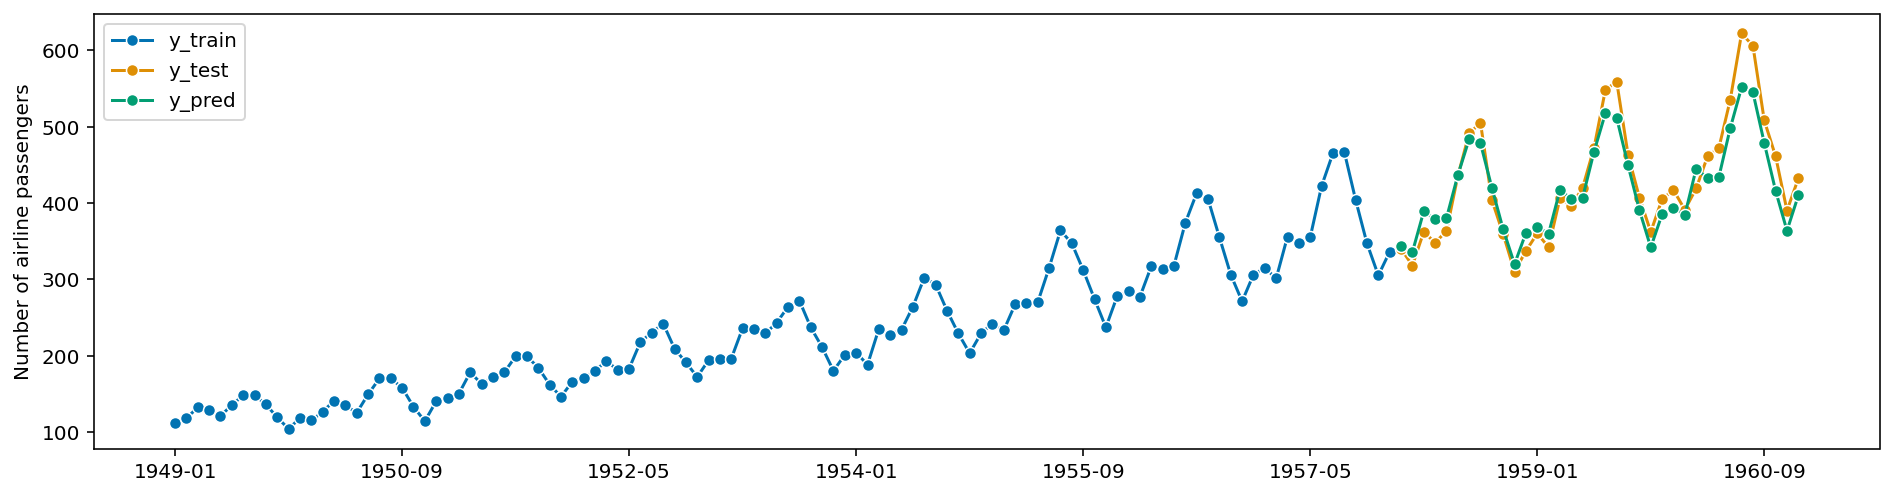

In [10]:
#plotting predictions
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

**And coupe de grâce: meme**

<img src="meme.png">